In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Distinguishing between *independent* and *comparative* leaky, gaze-dependent evidence accumulation with inhibition

In this notebook, I investigate differences between two types of evidence accumulation:

1. Independent accumulation: Here, evidence for each item is accumulated, independently of all other items.
2. Comparative accumulation: Here, **relative** evidence for each item is accumulated, by comparing its value to the mean of all other items' values, and accumulating the result of this operation.

Formally, independent evidence accumulation for one item $i$ is given by:

$$A_i(t+1) = S \times A_i(t) + \theta_i v_i$$

and comparative accumulation for an item $i$ by

$$R_i(t+1)= S \times R_i(t) + (\theta_i v_i - (\text{mean}_{j \ne i}(\theta_j v_j)))$$



where in both cases $S$ is a square feedback matrix, that is multiplied with the previous accumulator state at each time point. The entries on $S$'s diagonal correspond control accumulation leak ($0 \le \lambda \le 1$, perfect memory for $\lambda = 1$, full leak of all previous information when $\lambda = 0$). Off diagonal elements $\phi$ control feedback between alternatives (so that, for example high values on one accumulator inhibit other accumulators).

$\theta_i$ is an alternative-wise gaze bias term ($0 \le \theta \le 1$) that is set to 1 while an item $i$ is fixated, effectively discounting values $v_i$ of non-fixated items.

Unlike traditional accumulation to bound models, we analyse a case without internal stopping rule. This means that there is not decision boundary at which a decision is triggered. Instead, accumulation occurs over a fixed sequence of fixations, and choice probabilities are derived from applying a softmax function over the final accumulator states. The softmax function is given by

$$s(x_i) = \frac{\exp{\beta x_i}}{\sum_{j=1}^n \exp{\beta x_j}}$$

where $\beta$ ($\beta \ge 0$) is the inverse-temperature parameter, that controls the degree of randomness in the choice probabilities (the softmax function returns equal choice probabilities for $\beta = 0$ and deterministically assigns asymptotically full probability to the highest $x_i$ for large $\beta$).

In [2]:
def softmax(x):
    """
    Simple softmax function over the last dimension of an array x.
    """
    x = x - x.max(axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

First we create some stimulus values:

In [3]:
V = np.array([1, 2, 4])
n = len(V)  # number of items

We set leak and gaze-bias parameters to somewhat reasonable values and build the feedback matrix S:

In [4]:
lam = 0.7  # 1 = no leak
phi = -0.2 # 0 = no inhibition
theta = 0.3  # 1 = no gaze-bias

S = np.ones((n, n)) * phi
np.fill_diagonal(S, lam)
S

array([[ 0.7, -0.2, -0.2],
       [-0.2,  0.7, -0.2],
       [-0.2, -0.2,  0.7]])

And generate a simple sequence of fixations:

In [5]:
fixations = np.array([0, 1, 2, 0, 1, 2])

Next, we simulate the accumulation process, using both variants (independent and comparative evidence accumulation):

In [6]:
# Initialize a contrast matrix
# When used as a dot product, the matrix effectively performs item-vs-mean(others) comparisons.
C = np.ones((n, n)) * (-1 / (n - 1))
np.fill_diagonal(C, 1)
C

array([[ 1. , -0.5, -0.5],
       [-0.5,  1. , -0.5],
       [-0.5, -0.5,  1. ]])

In [7]:
A = np.zeros((len(fixations) + 1, n))
R = np.zeros_like(A)

for f, fixation in enumerate(fixations):
    theta_v = np.ones(n) * theta
    theta_v[fixation] = 1.0
    A[f + 1, :] = S.dot(A[f, :]) + theta_v * V
    R[f + 1, :] = S.dot(R[f, :]) + C.dot(theta_v * V)

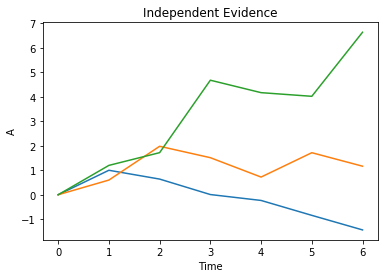

In [8]:
plt.plot(A)
plt.title('Independent Evidence')
plt.xlabel('Time')
plt.ylabel('A');

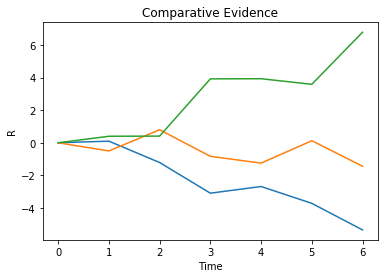

In [9]:
plt.plot(R)
plt.title('Comparative Evidence')
plt.xlabel('Time')
plt.ylabel('R');

Absolute and relative evidence accumulation trajectories obviously differ.

## Comparative evidence: No difference between "online" vs. "offline" comparison

Does it matter, whether the item-vs-mean(other) comparison is performed online, during the accumulation, can its values be obtained after the accumulation process?
To check this, we apply the contrast matrix $C$ to each time step of the absolute accumulation trajectory $A$:

In [10]:
R.shape

(7, 3)

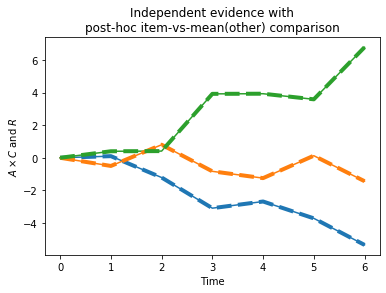

In [11]:
plt.plot(A.dot(C))
for i in range(n):
    plt.plot(R[:, i], color=f'C{i}', ls='--', lw=4)
plt.title('Independent evidence with\npost-hoc item-vs-mean(other) comparison')
plt.xlabel('Time')
plt.ylabel(r'$A \times C$ and $R$');

In [12]:
np.allclose(R, A.dot(C))

True

As it turns out, there is no difference between accumulating comparative item values (with leak, inhibition and gaze bias) or contrasting trajectories from independent accumulation.

## No difference between independent and comparative integration, when used with softmax

Next, I will demonstrate, that if choice probabilities from these models are derived using a softmax function with inverse temperature parameter $\beta$ on the final accumulator states, the independent and comparative (item-vs-mean(others)) variants are mathematically equivalent up to a transform of the inverse-temperature parameter $\beta$:

The trajectories *and final accumulator values* differ between independent and comparative accumulation:

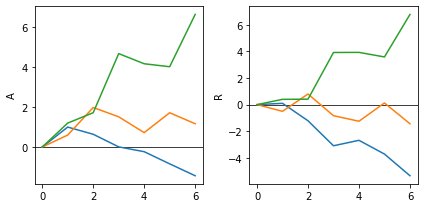

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].plot(A)
axs[0].set_ylabel('A')
axs[1].plot(R)
axs[1].set_ylabel('R')
for ax in axs:
    ax.axhline(0, color='black', linewidth=0.75, zorder=-1)

fig.tight_layout()

In [14]:
A[-1]

array([-1.437436,  1.166438,  6.640452])

In [15]:
R[-1]

array([-5.340881, -1.43507 ,  6.775951])

The choice probabilities obtained using a softmax function are also different:

In [16]:
softmax(A[-1])

array([3.08934100e-04, 4.17555259e-03, 9.95515513e-01])

In [17]:
softmax(R[-1])

array([5.46520420e-06, 2.71567978e-04, 9.99722967e-01])

However, as it turns out, when an inverse temperature parameter is added to the softmax function (and freely estimated), the predicted choice probabilities from both models are simple transforms of each other:

In [18]:
beta = 1
softmax(beta * A[-1])

array([3.08934100e-04, 4.17555259e-03, 9.95515513e-01])

In [19]:
softmax(beta * ((n - 1) / n) * R[-1])

array([3.08934100e-04, 4.17555259e-03, 9.95515513e-01])

Specifically, both models are identical, when the $\beta$ parameter in the *relative* accumulation model is $\frac{n-1}{n}$ times the $\beta$ parameter from the *absolute* accumulation model, where $n$ is the number of items.
In other words, if a softmax function with inverse temperature parameter is used to derive choice probabilities from such models' final accumulator states, it does not matter, whether the evidence signal is "absolute" or "relative" (item-vs-mean(others)).

The two implementations obviously differ, when a decision boundary is introduced.
I also suspect, that they only align when the relative implementation uses an item-vs-mean(others) procedure, and I predict that this is not the case for other possible mechanisms (like an item-vs-next process, as used in the maDDM; Krajbich & Rangel, 2011).

# Time-varying (e.g., gaze-dependent) feedback matrix S

While the equivalence between absolute and comparative evidence accumulation holds, even in cases with inhibition between accumulators and leak, equivalence is not given when the feedback matrix $S$ changes over time, as for instance with gaze-dependent inhibition or leak:

### Gaze-dependent leak, constant feedback

First, I simulate a case, where leakage only applies to non-fixated alternatives:

In [20]:
A = np.zeros((len(fixations) + 1, n))
R = np.zeros_like(A)

for f, fixation in enumerate(fixations):
    theta_v = np.ones(n) * theta
    theta_v[fixation] = 1.0
    lam_v = np.ones(n) * lam
    lam_v[fixation] = 1
    np.fill_diagonal(S, lam_v)
    print(f"Fixation {f}: Alt {fixation}, S_f:", '\n', S, '\n')
    A[f + 1, :] = S.dot(A[f, :]) + theta_v * V
    R[f + 1, :] = S.dot(R[f, :]) + C.dot(theta_v * V)

Fixation 0: Alt 0, S_f: 
 [[ 1.  -0.2 -0.2]
 [-0.2  0.7 -0.2]
 [-0.2 -0.2  0.7]] 

Fixation 1: Alt 1, S_f: 
 [[ 0.7 -0.2 -0.2]
 [-0.2  1.  -0.2]
 [-0.2 -0.2  0.7]] 

Fixation 2: Alt 2, S_f: 
 [[ 0.7 -0.2 -0.2]
 [-0.2  0.7 -0.2]
 [-0.2 -0.2  1. ]] 

Fixation 3: Alt 0, S_f: 
 [[ 1.  -0.2 -0.2]
 [-0.2  0.7 -0.2]
 [-0.2 -0.2  0.7]] 

Fixation 4: Alt 1, S_f: 
 [[ 0.7 -0.2 -0.2]
 [-0.2  1.  -0.2]
 [-0.2 -0.2  0.7]] 

Fixation 5: Alt 2, S_f: 
 [[ 0.7 -0.2 -0.2]
 [-0.2  0.7 -0.2]
 [-0.2 -0.2  1. ]] 



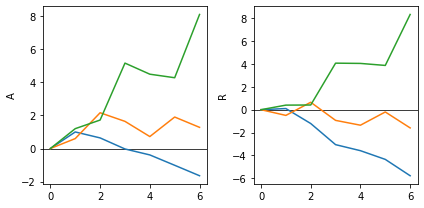

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].plot(A)
axs[0].set_ylabel('A')
axs[1].plot(R)
axs[1].set_ylabel('R')
for ax in axs:
    ax.axhline(0, color='black', linewidth=0.75, zorder=-1)

fig.tight_layout()

In [22]:
beta = 1
softmax(beta * A[-1])

array([5.85982531e-05, 1.09041418e-03, 9.98850988e-01])

In [23]:
softmax(beta * ((n - 1) / n) * R[-1])

array([8.19608583e-05, 1.33379801e-03, 9.98584241e-01])

The transform does **not** yield identical results this time.

### Gaze-dependent feedback, constant leak

Second, we look at a case, where leakage is constant, but inhibition is gaze-dependent so that only the fixated alternative exerts inhibition over other alternatives:

In [24]:
A = np.zeros((len(fixations) + 1, n))
R = np.zeros_like(A)

for f, fixation in enumerate(fixations):
    theta_v = np.ones(n) * theta
    theta_v[fixation] = 1.0
    S = np.zeros((n, n))
    S[:, fixation] = phi
    np.fill_diagonal(S, lam)
    print(f"Fixation {f}: Alt {fixation}, S_f:", '\n', S, '\n')
    A[f + 1, :] = S.dot(A[f, :]) + theta_v * V
    R[f + 1, :] = S.dot(R[f, :]) + C.dot(theta_v * V)

Fixation 0: Alt 0, S_f: 
 [[ 0.7  0.   0. ]
 [-0.2  0.7  0. ]
 [-0.2  0.   0.7]] 

Fixation 1: Alt 1, S_f: 
 [[ 0.7 -0.2  0. ]
 [ 0.   0.7  0. ]
 [ 0.  -0.2  0.7]] 

Fixation 2: Alt 2, S_f: 
 [[ 0.7  0.  -0.2]
 [ 0.   0.7 -0.2]
 [ 0.   0.   0.7]] 

Fixation 3: Alt 0, S_f: 
 [[ 0.7  0.   0. ]
 [-0.2  0.7  0. ]
 [-0.2  0.   0.7]] 

Fixation 4: Alt 1, S_f: 
 [[ 0.7 -0.2  0. ]
 [ 0.   0.7  0. ]
 [ 0.  -0.2  0.7]] 

Fixation 5: Alt 2, S_f: 
 [[ 0.7  0.  -0.2]
 [ 0.   0.7 -0.2]
 [ 0.   0.   0.7]] 



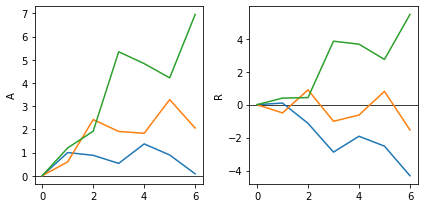

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].plot(A)
axs[0].set_ylabel('A')
axs[1].plot(R)
axs[1].set_ylabel('R')
for ax in axs:
    ax.axhline(0, color='black', linewidth=0.75, zorder=-1)

fig.tight_layout()

In [26]:
beta = 1
softmax(beta * A[-1])

array([0.00102976, 0.00739002, 0.99158022])

In [27]:
softmax(beta * ((n - 1) / n) * R[-1])

array([0.00145712, 0.0092773 , 0.98926559])

Again, the transform does **not** yield identical results.

# Summary

We've shown that independent and comparative evidence accumulation can not be distinguished if a softmax function with free inverse temperature parameter is applied to final accumulator values to obtain predicted choice probabilities when the feedback matrix $S$ is constant. This includes all cases with constant leak, inhibition and alternative-wise gaze biases. The equivalency is lost, when feedback or inhibition are time varying, for example via gaze-dependence.